In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/customer/Customers.csv


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier

In [10]:
df = pd.read_csv("/kaggle/input/customer/Customers.csv")
df.head()

,customer_ID,Contact_Last_Name,Contact_First_Name,Street,City,State,Zip,Country,Age,Marital_Status,Gender,Number_Of_Dependents
0,1,Chaney,Jemima,5584 Orci Street,Lexington,Kentucky,36751,United States,65,Married,Male,0
1,2,Collins,Colt,"P.O. Box 643, 8508 At, St.",Boston,Massachusetts,25388,United States,65,Married,Male,0
2,3,Crawford,Glenna,"P.O. Box 890, 8204 Lectus Rd.",Milwaukee,Wisconsin,33343,United States,65,NaN,Male,0
3,4,Fisher,Sophia,Ap #274-5091 Vel Avenue,Salem,Oregon,90464,United States,65,Married,Female,0
4,5,Gonzales,Evan,798-923 Ante Street,Olympia,Washington,82930,United States,65,Married,Female,0


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   customer_ID           10000 non-null  int64 
 1   Contact_Last_Name     10000 non-null  object
 2   Contact_First_Name    10000 non-null  object
 3   Street                10000 non-null  object
 4   City                  10000 non-null  object
 5   State                 10000 non-null  object
 6   Zip                   10000 non-null  int64 
 7   Country               10000 non-null  object
 8   Age                   10000 non-null  int64 
 9   Marital_Status        8111 non-null   object
 10  Gender                9010 non-null   object
 11  Number_Of_Dependents  10000 non-null  int64 
dtypes: int64(4), object(8)
memory usage: 937.6+ KB


In [12]:
print(df.isnull().sum())

customer_ID                0
Contact_Last_Name          0
Contact_First_Name         0
Street                     0
City                       0
State                      0
Zip                        0
Country                    0
Age                        0
Marital_Status          1889
Gender                   990
Number_Of_Dependents       0
dtype: int64


In [13]:
def encode_categoricals(df):
    le_dict = {}
    for col in df.select_dtypes(include=['object']).columns:
        le = LabelEncoder()
        df[col] = df[col].astype(str)  # handle NaN as 'nan'
        df[col] = le.fit_transform(df[col])
        le_dict[col] = le
    return df, le_dict

# Encode for ML
df_encoded, encoders = encode_categoricals(df.copy())

In [17]:
def fill_missing_xgb(df, target_col):
    nan_label = encoders[target_col].transform(['nan'])[0]
    known = df[df[target_col] != nan_label]
    unknown = df[df[target_col] == nan_label]
    
    if unknown.empty:
        return df
    
    X = known.drop(columns=[target_col])
    y = known[target_col]

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, stratify=y, test_size=0.2, random_state=42
    )
    
    # XGBoost Model
    clf = XGBClassifier(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        use_label_encoder=False,
        eval_metric="mlogloss"
    )
    
    clf.fit(X_train, y_train)
    print(f"{target_col} Accuracy:", clf.score(X_test, y_test))
    
    preds = clf.predict(unknown.drop(columns=[target_col]))
    df.loc[unknown.index, target_col] = preds
    
    return df

In [18]:
from sklearn.ensemble import RandomForestClassifier

def fill_missing_rf(df, target_col):
    nan_label = encoders[target_col].transform(['nan'])[0]
    known = df[df[target_col] != nan_label]
    unknown = df[df[target_col] == nan_label]
    
    if unknown.empty:
        return df
    
    X = known.drop(columns=[target_col])
    y = known[target_col]
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, stratify=y, test_size=0.2, random_state=42
    )
    
    clf = RandomForestClassifier(n_estimators=200, random_state=42)
    clf.fit(X_train, y_train)
    print(f"{target_col} Accuracy:", clf.score(X_test, y_test))
    
    preds = clf.predict(unknown.drop(columns=[target_col]))
    df.loc[unknown.index, target_col] = preds
    
    return df


In [20]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

# Load data
df = pd.read_csv("/kaggle/input/customer/Customers.csv")

# Identify categorical columns (exclude ID-like columns)
id_cols = ["CustomerID", "Name", "Email"]  # adjust based on your dataset
cat_cols = [col for col in df.select_dtypes(include=['object']).columns if col not in id_cols]

# Encode only selected categorical columns
encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    df[col] = df[col].astype(str)  # NaN -> 'nan'
    df[col] = le.fit_transform(df[col])
    encoders[col] = le

# Function for missing imputation
def fill_missing(df, target_col, model="rf"):
    nan_label = encoders[target_col].transform(['nan'])[0]
    known = df[df[target_col] != nan_label]
    unknown = df[df[target_col] == nan_label]
    
    if unknown.empty:
        return df
    
    X = known.drop(columns=[target_col])
    y = known[target_col]
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, stratify=y, test_size=0.2, random_state=42
    )
    
    if model == "rf":
        clf = RandomForestClassifier(n_estimators=200, random_state=42)
    else:
        clf = XGBClassifier(
            n_estimators=500,
            learning_rate=0.05,
            max_depth=6,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42,
            use_label_encoder=False,
            eval_metric="mlogloss"
        )
    
    clf.fit(X_train, y_train)
    print(f"{target_col} Accuracy:", clf.score(X_test, y_test))
    
    preds = clf.predict(unknown.drop(columns=[target_col]))
    df.loc[unknown.index, target_col] = preds
    return df

# Fill Gender with RandomForest
df = fill_missing(df, "Gender", model="rf")

# Fill Marital_Status with XGBoost
df = fill_missing(df, "Marital_Status", model="xgb")

# Decode only categorical columns we encoded
for col, le in encoders.items():
    df[col] = le.inverse_transform(df[col])

# Save cleaned dataset
df.to_csv("Customers_filled_xgb.csv", index=False)


Gender Accuracy: 0.8251942286348501
Marital_Status Accuracy: 0.5489833641404805


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


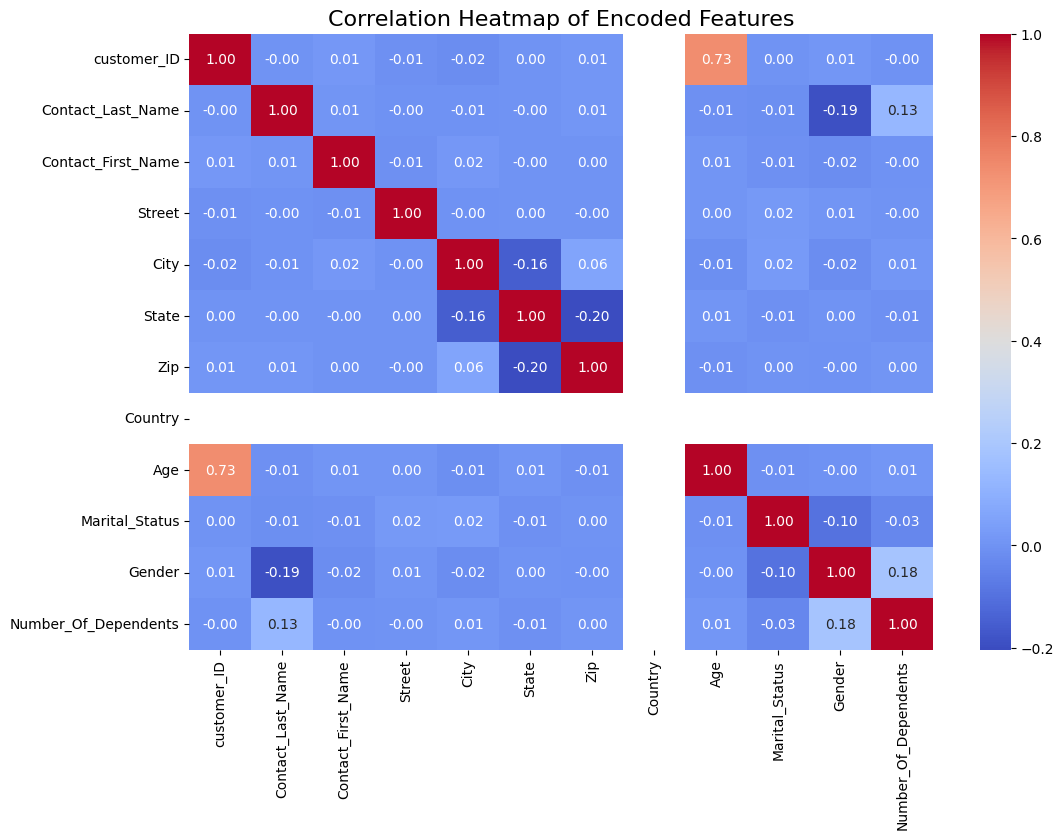


Correlation with Gender:
Gender                  1.000000
Number_Of_Dependents    0.183886
customer_ID             0.008582
Street                  0.007011
State                   0.001063
Zip                    -0.004453
Age                    -0.004489
Contact_First_Name     -0.016660
City                   -0.017657
Marital_Status         -0.097456
Contact_Last_Name      -0.193810
Country                      NaN
Name: Gender, dtype: float64

Correlation with Marital_Status:
Marital_Status          1.000000
City                    0.022951
Street                  0.018293
Zip                     0.002673
customer_ID             0.000243
Age                    -0.008524
State                  -0.009247
Contact_First_Name     -0.010710
Contact_Last_Name      -0.012093
Number_Of_Dependents   -0.034665
Gender                 -0.097456
Country                      NaN
Name: Marital_Status, dtype: float64


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


In [22]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# Load data
df = pd.read_csv("/kaggle/input/customer/Customers.csv")

# Copy for encoding
df_enc = df.copy()

# Encode categorical columns (skip ID-like ones)
id_cols = ["CustomerID", "Name", "Email"]  # adjust as per your dataset
cat_cols = [col for col in df_enc.select_dtypes(include=['object']).columns if col not in id_cols]

encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    df_enc[col] = df_enc[col].astype(str)  # NaN → 'nan'
    df_enc[col] = le.fit_transform(df_enc[col])
    encoders[col] = le

# Correlation matrix
corr = df_enc.corr(numeric_only=True)

# Heatmap
plt.figure(figsize=(12,8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Heatmap of Encoded Features", fontsize=16)
plt.show()

# Focus on Gender + Marital_Status
print("\nCorrelation with Gender:")
print(corr["Gender"].sort_values(ascending=False))

print("\nCorrelation with Marital_Status:")
print(corr["Marital_Status"].sort_values(ascending=False))
